In [12]:
import plotly.express as px
import pandas as pd

data = pd.read_csv("dataset_3.csv", infer_datetime_format=True, parse_dates=True)
data["magnitude"] = data["magnitude"].round(1)
data["date"] = pd.to_datetime(data[["year", "month", "day", "hour", "minute"]])
data = data.sort_values("date")
data = data[data["date"] < "2023-01-01"]
data["time_since_last_earthquake"] = data.date.diff().map(
    lambda x: x.total_seconds() / 86400
)
data

,longitude,latitude,year,month,day,hour,minute,second,magnitude,depth,date,time_since_last_earthquake
21,26.600,40.500,1900,2,7,0,0,0.0,5.0,10.00,1900-02-07 00:00:00,NaN
22,29.260,40.430,1900,6,18,17,40,0.0,5.2,10.00,1900-06-18 17:40:00,131.736111
23,26.300,40.500,1900,7,12,2,5,0.0,4.9,10.00,1900-07-12 02:05:00,23.350694
24,30.100,40.440,1900,8,1,8,40,0.0,5.2,10.00,1900-08-01 08:40:00,20.274306
25,36.400,40.300,1900,8,6,13,25,0.0,5.3,10.00,1900-08-06 13:25:00,5.197917
...,...,...,...,...,...,...,...,...,...,...,...,...
1928,30.946,40.808,2022,12,3,4,59,20.0,4.1,14.20,2022-12-03 04:59:00,0.423611
1929,38.684,39.854,2022,12,10,10,29,26.0,3.6,7.05,2022-12-10 10:29:00,7.229167
1930,27.110,40.364,2022,12,13,3,21,16.0,4.3,12.12,2022-12-13 03:21:00,2.702778
1931,40.537,39.859,2022,12,18,8,57,49.0,3.9,10.21,2022-12-18 08:57:00,5.233333


In [46]:
from scipy.stats import poisson
from scipy.optimize import minimize
import numpy as np

In [42]:
data2 = data[data['magnitude'] >= 6.0].groupby("year")["magnitude"].count()
data2.index = pd.to_datetime(data2.index, format="%Y")
new_indx = pd.date_range(start="1900-01-01", end="2022-12-31", freq="YS")
data2 = data2.reindex(new_indx, fill_value=0)
data2

1900-01-01    0
1901-01-01    0
1902-01-01    0
1903-01-01    1
1904-01-01    0
             ..
2018-01-01    0
2019-01-01    0
2020-01-01    0
2021-01-01    0
2022-01-01    0
Freq: AS-JAN, Name: magnitude, Length: 123, dtype: int64

In [52]:
data2.value_counts()


0    95
1    21
2     6
3     1
Name: magnitude, dtype: int64

In [61]:
lambda_mle = data2.value_counts()[1:].sum()/data2.value_counts().sum()
lambda_mle

0.22764227642276422

In [62]:
years = [5,10,20, 30, 40,50]

for year in years:
    print(f"Year - Probability: {year}, {np.round(1-np.exp(-year*lambda_mle)*(year*lambda_mle), 3)}")

Year - Probability: 5, 0.635
Year - Probability: 10, 0.766
Year - Probability: 20, 0.952
Year - Probability: 30, 0.993
Year - Probability: 40, 0.999
Year - Probability: 50, 1.0


In [87]:
magnitudes = np.round(np.arange(4, 6.5, 0.2), 3)
years = [5,10,20, 30, 40,50, 100]

prob_table = []
for magnitude in magnitudes:
    risks = {}
    data2 = data[data['magnitude'] >= magnitude].groupby("year")["magnitude"].count()
    data2.index = pd.to_datetime(data2.index, format="%Y")
    new_indx = pd.date_range(start="1900-01-01", end="2022-12-31", freq="YS")
    data2 = data2.reindex(new_indx, fill_value=0)
    lambda_mle = data2.value_counts()[1:].sum()/data2.value_counts().sum()
    for year in years:
        risks[f'Risk in {year} Years']= np.round(1-np.exp(-year*lambda_mle)*(year*lambda_mle), 3)
    prob_table.append({'magnitude':magnitude, **risks})

prob_table = pd.DataFrame(prob_table)
prob_table

C:\Users\murat\AppData\Local\Temp\ipykernel_19540\3415546984.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

C:\Users\murat\AppData\Local\Temp\ipykernel_19540\3415546984.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

C:\Users\murat\AppData\Local\Temp\ipykernel_19540\3415546984.py:11: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i

,magnitude,Risk in 5 Years,Risk in 10 Years,Risk in 20 Years,Risk in 30 Years,Risk in 40 Years,Risk in 50 Years,Risk in 100 Years
0,4.0,0.944,0.999,1.000,1.000,1.000,1.000,1.0
1,4.2,0.942,0.998,1.000,1.000,1.000,1.000,1.0
2,4.4,0.940,0.998,1.000,1.000,1.000,1.000,1.0
3,4.6,0.924,0.997,1.000,1.000,1.000,1.000,1.0
4,4.8,0.919,0.997,1.000,1.000,1.000,1.000,1.0
5,5.0,0.897,0.994,1.000,1.000,1.000,1.000,1.0
6,5.2,0.863,0.988,1.000,1.000,1.000,1.000,1.0
7,5.4,0.807,0.971,1.000,1.000,1.000,1.000,1.0
8,5.6,0.712,0.911,0.996,1.000,1.000,1.000,1.0
9,5.8,0.653,0.826,0.978,0.998,1.000,1.000,1.0


<AxesSubplot: >

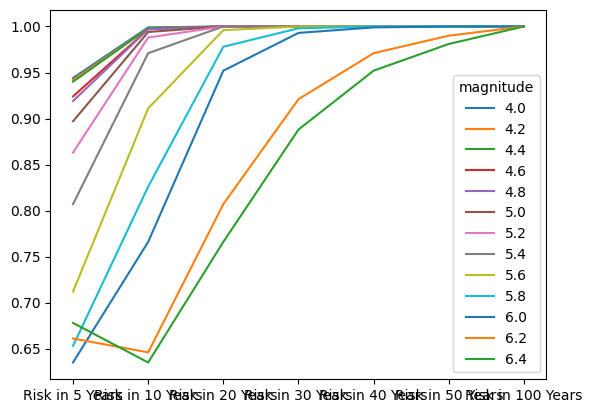

In [89]:
prob_table.set_index("magnitude", inplace=True)
prob_table.T.plot()